In [17]:
import os
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import layers, models

# Define dataset path
dataset_path = r"C:\Users\alexs\Documents\Python Scripts\Trees in Satellite Imagery\Trees in Satellite Imagery"

# Define class names
class_names = ["Forest", "Pasture", "River", "AnnualCrop", "Industrial", "SeaLake"]

# Regex pattern to extract class names from filenames
def extract_class_from_filename(filename):
    match = re.match(r"(Forest|Pasture|River|AnnualCrop|Industrial|SeaLake)_", filename)
    return match.group(1) if match else None  # Return matched class name

# Load images and assign correct labels
def load_images_with_labels(directory):
    image_paths = []
    labels = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.png')):  # Ensure it's an image file
                label = extract_class_from_filename(file)
                if label:
                    image_paths.append(os.path.join(root, file))
                    labels.append(class_names.index(label))  # Convert to numerical index

    return image_paths, labels

# Get image paths and corresponding labels
image_paths, labels = load_images_with_labels(dataset_path)
print(f"Total Images Loaded: {len(image_paths)}")

Total Images Loaded: 10400


In [18]:
# Compute class weights for handling imbalance
class_counts = Counter(labels)
total_samples = sum(class_counts.values())
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in class_counts.items()}
print(f"Class Weights: {class_weights}")

Class Weights: {3: 2.5084418716835506, 4: 0.6983615363953801, 5: 0.8551225127446144, 0: 0.5777777777777777, 1: 8.666666666666666, 2: 0.8666666666666667}


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Convert image paths & labels into TensorFlow Dataset
image_size = (128, 128)

def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust based on image format
    image = tf.image.resize(image, image_size)  # Resize to match input size
    image = image / 255.0  # Normalize pixel values
    return image, label

# Shuffle the dataset before splitting to avoid sequential class distribution
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=len(image_paths))  # Ensures proper class mixing

# Split dataset before batching
dataset_size = len(image_paths)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

train_dataset = dataset.take(train_size)  # First 80% for training
val_dataset = dataset.skip(train_size)  # Remaining 20% for validation

# Confirm dataset sizes before batching
print(f"Training dataset size before batching: {train_size}")
print(f"Validation dataset size before batching: {val_size}")

# Apply transformations after splitting
batch_size = 32

train_dataset = (
    train_dataset.shuffle(buffer_size=1000)  # Reapply shuffle for training only
                 .batch(batch_size)  
                 .prefetch(tf.data.AUTOTUNE)
)

val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Quick check: print a few batches to confirm label distribution
for images, labels in train_dataset.take(3):
    print(f"Batch Labels: {labels.numpy()}")

for images, labels in val_dataset.take(3):
    print(f"Validation Batch Labels: {labels.numpy()}")


Training dataset size before batching: 8320
Validation dataset size before batching: 2080
Batch Labels: [4 4 5 0 5 2 5 2 3 4 2 4 4 4 4 0 0 2 5 5 2 0 4 0 0 4 2 4 2 1 5 0]
Batch Labels: [3 4 5 4 3 0 0 0 4 5 2 0 0 2 4 5 5 0 2 0 0 0 3 2 0 3 4 2 5 4 2 5]
Batch Labels: [4 0 4 2 5 0 2 3 5 0 2 4 2 5 5 0 5 4 2 5 2 4 2 5 4 0 2 5 4 2 2 0]
Validation Batch Labels: [0 2 4 5 2 2 0 0 5 4 4 5 5 4 5 2 4 2 2 4 2 0 4 0 0 5 5 0 4 5 2 4]
Validation Batch Labels: [4 2 3 0 4 0 0 5 4 4 0 0 4 2 4 5 5 3 5 2 0 5 5 5 3 3 5 2 5 3 2 0]
Validation Batch Labels: [5 2 5 1 0 2 5 5 3 2 2 0 0 5 0 5 4 0 3 4 4 0 4 0 3 5 0 4 0 0 0 5]


In [20]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Explicit input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # Multi-class output
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse since labels are integers
              metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights  # Apply class weighting
)


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - accuracy: 0.4556 - loss: 1.3158 - val_accuracy: 0.6216 - val_loss: 0.9141
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.6583 - loss: 0.9574 - val_accuracy: 0.6207 - val_loss: 0.9374
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.6994 - loss: 0.8445 - val_accuracy: 0.8000 - val_loss: 0.5372
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.7121 - loss: 0.8025 - val_accuracy: 0.8500 - val_loss: 0.4121
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - accuracy: 0.8103 - loss: 0.5540 - val_accuracy: 0.8462 - val_loss: 0.3942
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.7934 - loss: 0.5728 - val_accuracy: 0.8154 - val_loss: 0.4608
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.8280 - loss: 0.5354 - val_accuracy: 0.8683 - val_loss: 0.3497
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.8233 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


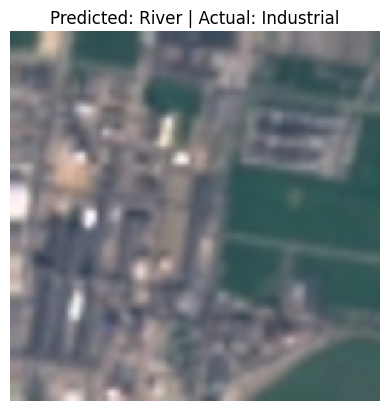

In [28]:
import random

# Get a batch from validation dataset
for images, labels in val_dataset.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# Pick a random index from the batch
random_index = random.randint(0, len(sample_images) - 1)
sample_image = sample_images[random_index]
sample_label = sample_labels[random_index]

# Predict the classification
prediction = model.predict(tf.expand_dims(sample_image, axis=0))
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

# Plot the image with predicted and actual labels
plt.imshow(sample_image)
plt.title(f"Predicted: {predicted_class} | Actual: {class_names[sample_label]}")
plt.axis("off")
plt.show()

